## CS164 LBA

#### Jacob Puthipiroj, Junhao Hou, Vinícius Miranda




### Destinations

We chose the following destinations to be part of our tour:

__Teatro Cólon__

The theater is internationally renowned due to its beautiful architecture, alluring interior, and remarkable acoustics. It's a prominent cultural landmark of the city and thus merits a visit by all tourists coming to Buenos Aires.

__Casa Rosada__

The presidential palace is famous for its pink-colored facade. The venue, known both for its political gravitas and aesthetic virtues, is a must-see.

__El Ateneo Grand Splendid__

The theater-turned-bookstore is considered the most beautiful in the world by National Geographic (Howard, 2019) and is a famous tourist attraction.

__Costanera__

We could not miss featuring an ecological landmark. The *Reserva Ecológica Costanera Sur* or Costanera, is a beautiful ecological reserve by the sea which also undoubtedly merits a visit.

__Cementerio de la Recoleta__

The cemetery is famous for housing the graves of prominent persons in the history of both Argentina and the world, such as Eva Perón, presidents of the country, and Napoleon's granddaughter.

__Obelisco__

The white stone landmark features prominently in postcards of the city and might be the most well-known monument of Argentina.

### Travel Time

We have estimated the travel time between all pairs of locations using Google Maps for both walking (Table 1) and public transportation (Table 2). Data was taken at 3 pm. Public transportation includes bus, metro, or walking; the travel time shown is for the first route recommended by Google Maps. Cells should be read as time from column location to row location, since the table for public transportation is not perfectly symmetric.

<br>
<center> **Table 1. Walking travel times from column location to row location (min).** </center>


| Destination | Teatro Cólon  | Casa Rosada | El Ateneo Grand Splendid   | Costanera | Cementerio de la Recoleta   | Obelisco  | 
|----|------|------|------|------|------|------|
|  Teatro Cólon  | 0|   21  | 21|   28  | 27|   5  | 
|   Casa Rosada  | 21|   0  | 42|   26  | 47|   16  | 
|   El Ateneo Grand Splendid  | 21|   42  | 0|   40  | 16| 25  | 
|   Costanera  | 28|  26  | 40| 0 | 48| 31 | 
|   Cementerio de la Recoleta  | 27| 47 | 16| 48 | 0|  32  | 
|   Obelisco  | 5|  16  | 25|  31| 32 |   0  | 
<br>
<center> **Table 2. Public transportation times from column location to row location (min).** </center>


| Destination | Teatro Cólon  | Casa Rosada | El Ateneo Grand Splendid   | Costanera | Cementerio de la Recoleta   | Obelisco  | 
|----|------|------|------|------|------|------|
|  Teatro Cólon  | 0|   12  | 14|   29  | 24|   5  | 
|   Casa Rosada  | 12|   0  | 16|   25  | 33|   9  | 
|   El Ateneo Grand Splendid  | 12|   17  | 0|   40  | 17| 13  | 
|   Costanera  | 28|  25  | 40| 0 | 46| 35 | 
|   Cementerio de la Recoleta  | 25| 32 | 18| 46 | 0|  26  | 
|   Obelisco  | 5|  10  | 12|  35| 23 |   0  | 

### TSP Optimization with MTZ Subtour Elimination

In [2]:
import cvxpy as cp
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

/Users/jacob/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


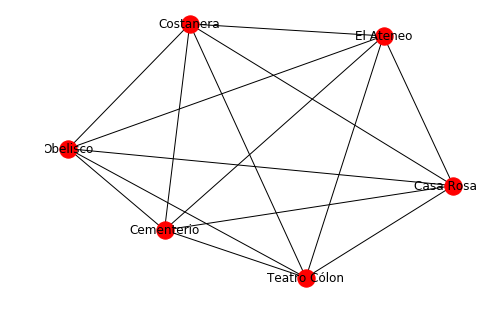

In [3]:
# Travel time matrices
A_walk = np.matrix([[0,21,21,28,27,5],
                    [21,0,42,26,47,16],
                    [21,42,0,40,16,25],
                    [28,26,40,0,48,31],
                    [27,47,16,48,0,32],
                    [5,16,25,31,32,0]])

A_trans = np.matrix([[0,12,14,29,24,5],
                     [12,0,16,25,33,9],
                     [12,17,0,40,17,13],
                     [28,25,40,0,46,35],
                     [25,32,18,46,0,26],
                     [5,10,12,35,23,0]])

# What is this for?
np.fill_diagonal(A_walk, 1000)
np.fill_diagonal(A_trans, 1000)

# Graph variables
node_to_city = {0: 'Teatro Cólon',
                1: 'Casa Rosada',
                2: 'El Ateneo',
                3: 'Costanera',
                4: 'Cementerio',
                5: 'Obelisco'}

G = nx.from_numpy_matrix(A_walk)
G = nx.relabel_nodes(G, node_to_city)
G = nx.drawing.nx_agraph.to_agraph(G)
nx.draw(G, with_labels = True)
plt.show()

In [13]:
def subtour(B):
    """
    this function returns the subtour from the matrix B.
    """
    node = 0
    subt = [node]
    while True:
        for j in range(6):
            #print (B[subt[-1], j])
            if B[subt[-1],j] > 0.99:
                if j not in subt:
                    subt.append(j)
                else:
                    return subt
                

In the following implementation, we have the decision variables of the optimization problem set as a 6 by 6 boolean matrix, indicating the path chosen which indicates the path chosen. The exact function that reads the decision matrix and returns the path is given in subtour. The objective function to be minimized is the distance of such a path, and hence is a composition of both the distance matrix A and the decision matrix B. In order for such a decision matrix to make sense, we require that there must be exactly one '1' per row and per column. 

The most challenging part of this implementation is the MTZ subtour elimination constraint. In general, there are approximately $n^2/2$ such constraints - in this case, there are 20, not counting the constraints for $u$ itself. These are called 'arc-constraints', and prevent subtours from forming by making constraints on the boolean matrix again - specifically, if there is a '1' in row $i$, column $j$, it forces $u_j \geq u_i + 1$. The consequence is that the only feasible value of $u_i$ is the position of node $i$ in the tour. 

In [11]:
# boolean matrix, indicating the trip
B = cp.Bool(6,6) 

# objective function
obj = cp.Minimize(sum([A_trans[i,:]*B[:,i] for i in range(6)])) 

# exactly one '1' per row and per column.
constraints = [(cp.sum_entries(B, axis=0) == np.matrix('1,1,1,1,1,1')), 
               (cp.sum_entries(B, axis=1) == np.matrix('1,1,1,1,1,1').transpose())]


u = cp.Variable(6) # auxilary variable for subtour elimination

constraints.append(u >= 0)

# mtz elimination constraints
for i in range(1,6):
    for j in range(1,6):
        if i != j:
            constraints.append(u[i] - u[j] + 6 * B[i,j] <= 5)

prob = cp.Problem(obj, constraints)
opt = prob.solve()

# Print results
print("Minimum time:", opt)
print("Optimal Path:", [node_to_city[i] for i in subtour(B.value)])

Minimum time: 116.00000000004682
Optimal Path: ['Teatro Cólon', 'El Ateneo', 'Cementerio', 'Costanera', 'Casa Rosada', 'Obelisco']


In [12]:
# boolean matrix, indicating the trip
B = cp.Bool(6,6) 

# objective function
obj = cp.Minimize(sum([A_walk[i,:]*B[:,i] for i in range(6)])) 

# exactly one '1' per row and per column.
constraints = [(cp.sum_entries(B, axis=0) == np.matrix('1,1,1,1,1,1')), 
               (cp.sum_entries(B, axis=1) == np.matrix('1,1,1,1,1,1').transpose())]


u = cp.Variable(6) # auxilary variable for subtour elimination

constraints.append(u >= 0)

# mtz elimination constraints
for i in range(1,6):
    for j in range(1,6):
        if i != j:
            constraints.append(u[i] - u[j] + 6 * B[i,j] <= 5)

prob = cp.Problem(obj, constraints)
opt = prob.solve()

# Print results
print("Minimum time:", opt)
print("Optimal Path:", [node_to_city[i] for i in subtour(B.value)])

Minimum time: 130.00000000144365
Optimal Path: ['Teatro Cólon', 'Obelisco', 'Casa Rosada', 'Costanera', 'El Ateneo', 'Cementerio']


### Tour Execution

## References

Howard, B. C. (2019, January 4). This is the world's most beautiful bookstore. __National Geographic__. Retrieved from [https://www.nationalgeographic.com/travel/destinations/south-america/argentina/buenos-aires/things-to-see-beautiful-bookshop/](https://www.nationalgeographic.com/travel/destinations/south-america/argentina/buenos-aires/things-to-see-beautiful-bookshop/)